# Building a Classifier (Titanic)
**Author:** Brendan Reed  
**Date:** Nov. 4, 2025  
**Objective:** Predicting a Categorical Target and Evaluating Performance using the Titanic data set

## Introduction

The Titanic dataset contains passenger information that can be used to try to predict survivors. The data includes information including ticket class, age, and sex (male/female).

## Section 1. Import and Inspect the Data
Load the titanic dataset from the directly from the seaborn library. 

In [ ]:
# all imports at the top, organized
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Load Titanic dataset
titanic = sns.load_dataset('titanic')
# Display a few records to verify
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## Section 2. Data Exploration and Preparation

### 2.1 Handle Missing Values and Clean Data
Impute missing values for age using the median:

In [3]:
median_age = titanic['age'].median()
titanic['age'] = titanic['age'].fillna(median_age)

Fill in missing values for embark_town using the mode:

In [4]:
mode_embark = titanic['embark_town'].mode()[0]
titanic['embark_town'] = titanic['embark_town'].fillna(mode_embark)

### 2.2 Feature Engineering
Create any new features that might be helpful for the model from the existing data. This is not making up new data - it is providing existing data in a more helpful, concise way for modeling.

In [5]:
# Create new feature
titanic['family_size'] = titanic['sibsp'] + titanic['parch'] + 1

# Map categories to numeric values
titanic['sex'] = titanic['sex'].map({'male': 0, 'female': 1})
titanic['embarked'] = titanic['embarked'].map({'C': 0, 'Q': 1, 'S': 2})
titanic['alone'] = titanic['alone'].astype(int)

## Section 3. Feature Selection and Justification
### 3.1 Choose features and target
- Select two or more input features (numerical for regression, numerical and/or categorical for classification)
- Use survived as the target. 
- We will do three input cases like the example. 

Case 1: 
- input features: alone
- target: survived

Case 2:
- input features - age
- target: survived

Case 3:
- input features -  age and family_size 
- target: survived

### 3.2 Define X (features) and y (target)
- Assign input features to X a pandas DataFrame with 1 or more input features
- Assign target variable to y (as applicable) - a pandas Series with a single target feature
- Again - use comments to run a single case at a time
- The follow starts with only the statements needed for case 1. 
- Double brackets [[ ]]  makes a 2D DataFrame
- Single brackets [ ]  make a 1D Series

In [6]:
# Case 1: Feature = alone

# Select the feature 'alone' as input
X1 = titanic[['alone']]

# Select 'survived' as the target for the same rows
y1 = titanic['survived']

In [7]:
# Case 2: Feature = age (drop if na or not available)

# Select the feature 'age', but drop rows where age is missing
X2 = titanic[['age']].dropna()

# Select the matching 'survived' values using the same index
y2 = titanic.loc[X2.index, 'survived']

In [8]:
# Case 3: Features = Age + Family Size (drop if na or not available)

# Select both 'age' and 'family_size', and drop rows where missing (na)
X3 = titanic[['age', 'family_size']].dropna()

# Select the corresponding 'survived' values for those rows
y3 = titanic.loc[X3.index, 'survived']

Reflection 3:

Why are these features selected?
- By examing how these features do in a model by themselves, we can see how the model performs when they are the only feature. This way, we can clearly see how predictive the features are.  

Are there features that are likely to be highly predictive of survival?
- I believe so. They do not have a particularly high correlation with survival, but the correlation found in the previous project is linear, and I beleive a classifier can do well even if there is weak linear correlation.

## Section 4. Train a Classification Model (Decision Tree)
### 4.1 Split the Data
We use iloc to select rows by integer positions returned by the splitter
.iloc[] lets us pull rows based on the row's location/position, rather than a label (it tends to be safe and fast)

### Reflection 1:
1) How many data instances are there? 891
2) How many features are there? 15
3) What are the names? ['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town',
       'alive', 'alone']
4) Are there any missing values? Yes...   
- Age: 177  
- embarked: 2  
- deck: 688  
- embark_town: 2  
5) Are there any non-numeric features? Yes...   
- sex          891 non-null    object    
- embarked     889 non-null    object  
- class        891 non-null    category
- who          891 non-null    object  
- adult_male   891 non-null    bool    
- deck         203 non-null    category
- embark_town  889 non-null    object  
- alive        891 non-null    object  
- alone        891 non-null    bool 

6) Are the data instances sorted on any of the attributes?  
Not that I have noticed.
7) What are the units of age?  
Years.
8) What are the minimum, median and max age?  
- minimum: 0.42
- median: 28
- max: 80
9) What two different features have the highest correlation?  
sibsp and alone

10) Are there any categorical features that might be useful for prediction?  
pclass - could indicate where a person was on the ship when it started sinking and could determine how likely they were to successfully evacuate.  
adult_male - women and children were prioritized first during the evacuation, so adult men had a higher likelyhood of not surviving. There is also a strong negative correlation between adult_male and survived (-0.557080).

## Section 2. Visualize Feature Distributions
### 2.1 Explore Data Patterns and Distributions

Create a scatter matrix. 


Since Titanic contains both numeric and categorical variables, we'll use only numeric values here.

Important:  Use only numeric attributes for the scatter matrix. If you want to explore categorical data, use count plots and bar plots instead.

array([[<Axes: xlabel='age', ylabel='age'>,
        <Axes: xlabel='fare', ylabel='age'>,
        <Axes: xlabel='pclass', ylabel='age'>],
       [<Axes: xlabel='age', ylabel='fare'>,
        <Axes: xlabel='fare', ylabel='fare'>,
        <Axes: xlabel='pclass', ylabel='fare'>],
       [<Axes: xlabel='age', ylabel='pclass'>,
        <Axes: xlabel='fare', ylabel='pclass'>,
        <Axes: xlabel='pclass', ylabel='pclass'>]], dtype=object)

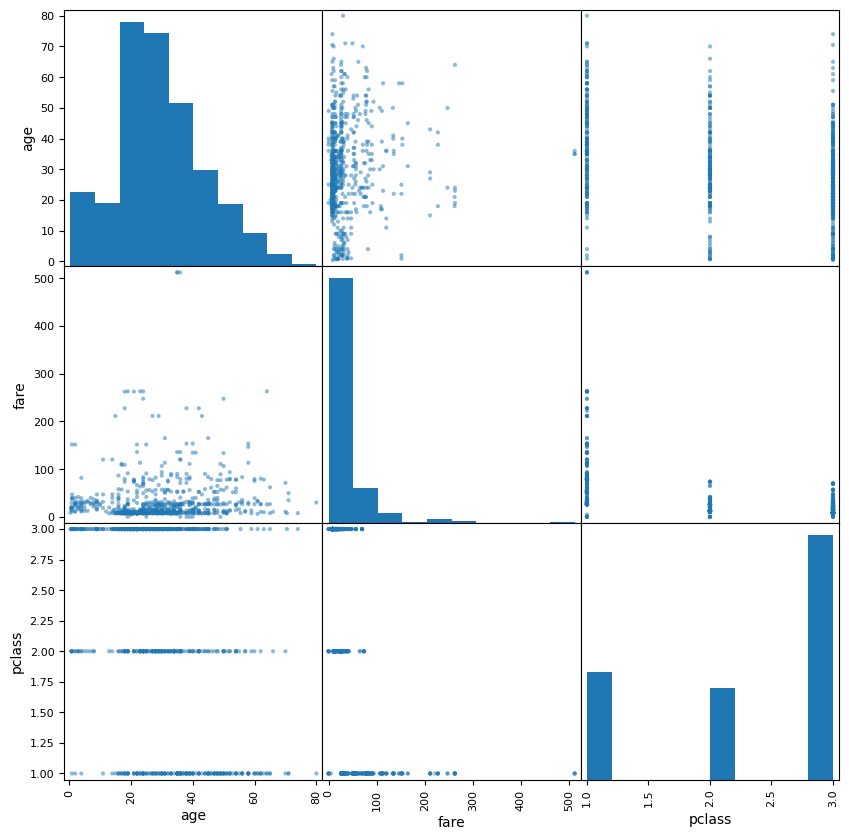

In [81]:
attributes = ['age', 'fare', 'pclass']
scatter_matrix(titanic[attributes], figsize=(10, 10))

Create a scatter plot of age vs fare, colored by gender:

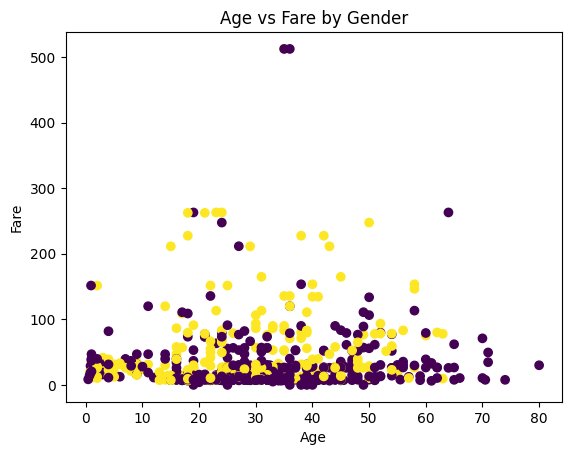

In [82]:
plt.scatter(titanic['age'], titanic['fare'], c=titanic['sex'].apply(lambda x: 0 if x == 'male' else 1))
plt.xlabel('Age')
plt.ylabel('Fare')
plt.title('Age vs Fare by Gender')
plt.show()

Create a grouped bar chart showing the relationship between sex and class.

C:\Users\reedb\AppData\Local\Temp\ipykernel_30360\1615962250.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = titanic.groupby(['class', 'sex']).size().unstack()


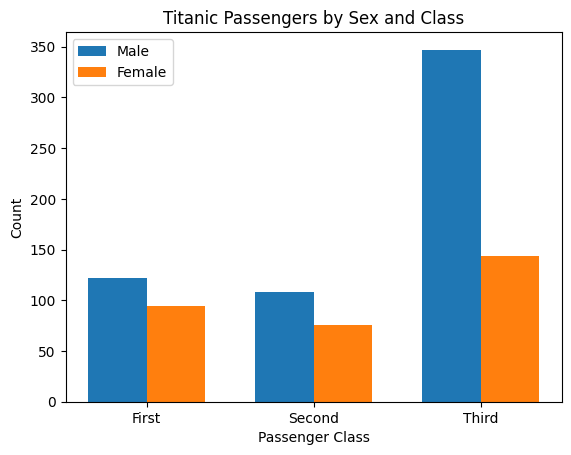

In [83]:
# Count number of passengers by sex and class
counts = titanic.groupby(['class', 'sex']).size().unstack()

# Plot grouped bars
x = range(len(counts))
bar_width = 0.35

plt.bar([i - bar_width/2 for i in x], counts['male'], width=bar_width, label='Male')
plt.bar([i + bar_width/2 for i in x], counts['female'], width=bar_width, label='Female')

# Labels and formatting
plt.xticks(x, counts.index)
plt.xlabel('Passenger Class')
plt.ylabel('Count')
plt.title('Titanic Passengers by Sex and Class')
plt.legend()

plt.show()


Create a histogram of age:

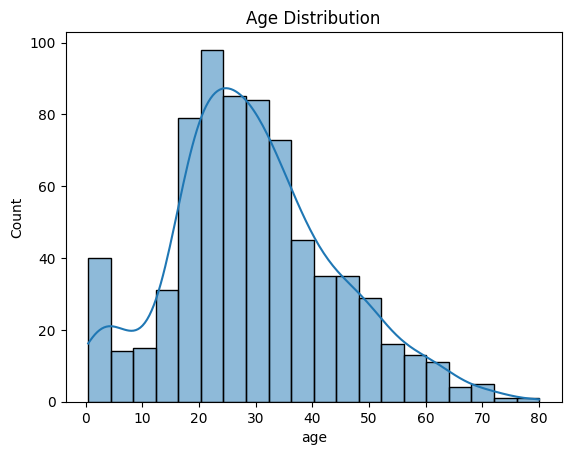

In [84]:
sns.histplot(titanic['age'], kde=True)
plt.title('Age Distribution')
plt.show()

Create a count plot for class and survival:

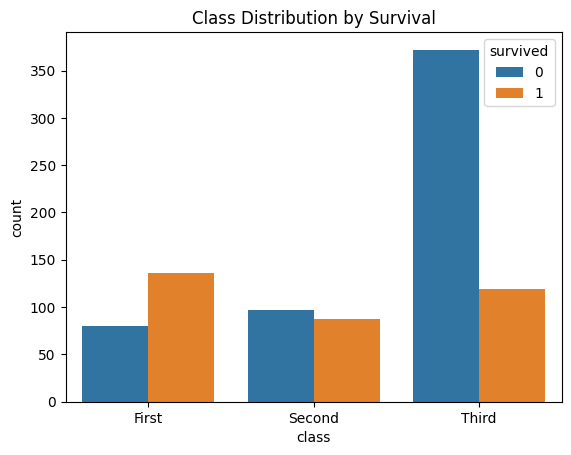

In [85]:
sns.countplot(x='class', hue='survived', data=titanic)
plt.title('Class Distribution by Survival')
plt.show()

### Reflection 2.1:
What patterns or anomalies do you notice?  
Men were far more likely to be in third class than second or first. Class is negatively correlated with survival. It could be that less men survived because they were in third class, or class is negatively corrlated with survival because less men in third class survived because they were men.  

Do any features stand out as potential predictors?  
pclass and sex  

Are there any visible class imbalances?  
Yes. Passengers in third class were much less likely to have survived.

### 2.2 Handle Missing Values and Clean Data
Age was missing values. We can impute missing values for age using the median:

In [86]:
titanic['age'].fillna(titanic['age'].median(), inplace=True)

C:\Users\reedb\AppData\Local\Temp\ipykernel_30360\3290119062.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic['age'].fillna(titanic['age'].median(), inplace=True)


Embark_town was missing values. We can drop missing values for embark_town (or fill with mode):

In [87]:
titanic['embark_town'].fillna(titanic['embark_town'].mode()[0], inplace=True)

C:\Users\reedb\AppData\Local\Temp\ipykernel_30360\3403561138.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic['embark_town'].fillna(titanic['embark_town'].mode()[0], inplace=True)


### 2.3 Feature Engineering
Create a new feature: Family size

In [88]:
titanic['family_size'] = titanic['sibsp'] + titanic['parch'] + 1

Convert categorical data to numeric:

In [89]:
titanic['sex'] = titanic['sex'].map({'male': 0, 'female': 1})
titanic['embarked'] = titanic['embarked'].map({'C': 0, 'Q': 1, 'S': 2})

Create a binary feature for 'alone':

In [90]:
titanic['alone'] = titanic['alone'].astype(int)

### Reflection 2.3
Why might family size be a useful feature for predicting survival?  
Perhaps families with children had a greater chance of evacuation and survival.  

Why convert categorical data to numeric?  
Features must be numeric to be used for some machine learning models.



## Section 3. Feature Selection and Justification
### 3.1 Choose features and target

- Select two or more input features (numerical for regression, numerical and/or categorical for classification)
- Select a target variable (as applicable)
  - Classification: Categorical target variable (e.g., gender, species).
  - Justify your selection with reasoning.

For classification, we’ll use survived as the target variable.

Input features: age, fare, pclass, sex, family_size  
Target: survived


### 3.2 Define X and y

- Assign input features to X
- Assign target variable to y (as applicable)

In [91]:
X = titanic[['age', 'fare', 'pclass', 'sex', 'family_size']]
y = titanic['survived']

### Reflection 3:

Why are these features selected?  
Because they are numerical.

Are there any features that are likely to be highly predictive of survival?  
Sex, fare, and pclass all have correlations with the target variable greater than 0.25, so I believe they could be helpful in predicting survival. Sex and the target variable have a correlation > 0.5, so it is likely to be highly predictive of survival.

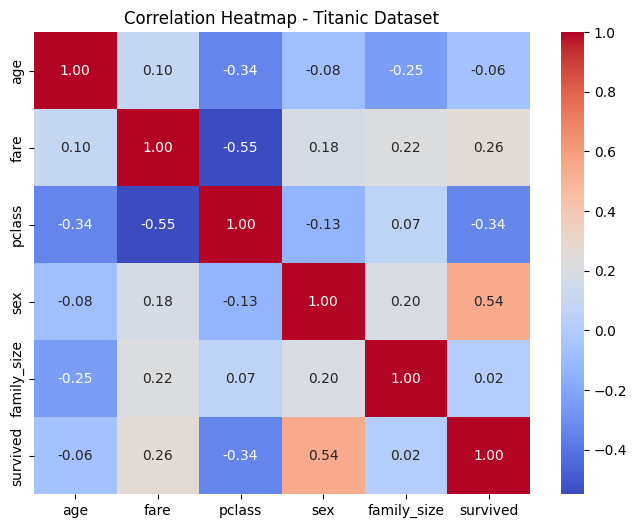

In [92]:
selected_features = pd.concat([X, y], axis=1)
corr = selected_features.corr(numeric_only=True)

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")

plt.title('Correlation Heatmap - Titanic Dataset')
plt.show()

## Section 4. Splitting
Split the data into training and test sets using train_test_split first and StratifiedShuffleSplit second. Compare.

In [9]:
# Case 1: Feature = alone
splitter1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
for train_idx1, test_idx1 in splitter1.split(X1, y1):

    X1_train = X1.iloc[train_idx1]
    X1_test  = X1.iloc[test_idx1]
    y1_train = y1.iloc[train_idx1]
    y1_test  = y1.iloc[test_idx1]

print('Case 1 - Alone:')
print('Train size:', len(X1_train), '| Test size:', len(X1_test))

Case 1 - Alone:
Train size: 712 | Test size: 179


In [10]:
# Case 2: Feature = age
splitter2 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
for train_idx2, test_idx2 in splitter2.split(X2, y2):
    X2_train = X2.iloc[train_idx2]
    X2_test  = X2.iloc[test_idx2]
    y2_train = y2.iloc[train_idx2]
    y2_test  = y2.iloc[test_idx2]

print('Case 2 - Age:')
print('Train size:', len(X2_train), '| Test size:', len(X2_test))

Case 2 - Age:
Train size: 712 | Test size: 179


In [11]:
# Case 3: Features = age + family_size
splitter3 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
for train_idx3, test_idx3 in splitter3.split(X3, y3):
    X3_train = X3.iloc[train_idx3]
    X3_test  = X3.iloc[test_idx3]
    y3_train = y3.iloc[train_idx3]
    y3_test  = y3.iloc[test_idx3]

print('Case 3 - Age + Family Size:')
print('Train size:', len(X3_train), '| Test size:', len(X3_test))

Case 3 - Age + Family Size:
Train size: 712 | Test size: 179


## 4.2 Create and Train Model (Decision Tree)

In [15]:
# CASE 1: Decision Tree using alone
tree_model1 = DecisionTreeClassifier()
tree_model1.fit(X1_train, y1_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [12]:
# CASE 2: Decision Tree using age
tree_model2 = DecisionTreeClassifier()
tree_model2.fit(X2_train, y2_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [13]:
# CASE 3: Decision Tree using age and family_size
tree_model3 = DecisionTreeClassifier()
tree_model3.fit(X3_train, y3_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


### 4.3 Predict and Evaluate Model Performance

In [16]:
# Predict on training data
y1_pred = tree_model1.predict(X1_train)
print("Results for Decision Tree on training data (Case 1 - alone):")
print(classification_report(y1_train, y1_pred))

# Predict on test data
y1_test_pred = tree_model1.predict(X1_test)
print("Results for Decision Tree on test data (Case 1 - alone):")
print(classification_report(y1_test, y1_test_pred))

Results for Decision Tree on training data (Case 1 - alone):
              precision    recall  f1-score   support

           0       0.69      0.69      0.69       439
           1       0.50      0.51      0.51       273

    accuracy                           0.62       712
   macro avg       0.60      0.60      0.60       712
weighted avg       0.62      0.62      0.62       712

Results for Decision Tree on test data (Case 1 - alone):
              precision    recall  f1-score   support

           0       0.71      0.65      0.68       110
           1       0.51      0.58      0.54        69

    accuracy                           0.63       179
   macro avg       0.61      0.62      0.61       179
weighted avg       0.64      0.63      0.63       179



In [17]:
# Predict on training data
y2_pred = tree_model2.predict(X2_train)
print("Results for Decision Tree on training data (Case 2 - age):")
print(classification_report(y2_train, y2_pred))

# Predict on test data
y2_test_pred = tree_model2.predict(X2_test)
print("Results for Decision Tree on test data (Case 2 - age):")
print(classification_report(y2_test, y2_test_pred))

Results for Decision Tree on training data (Case 2 - age):
              precision    recall  f1-score   support

           0       0.68      0.92      0.78       439
           1       0.69      0.29      0.41       273

    accuracy                           0.68       712
   macro avg       0.68      0.61      0.60       712
weighted avg       0.68      0.68      0.64       712

Results for Decision Tree on test data (Case 2 - age):
              precision    recall  f1-score   support

           0       0.63      0.89      0.74       110
           1       0.50      0.17      0.26        69

    accuracy                           0.61       179
   macro avg       0.57      0.53      0.50       179
weighted avg       0.58      0.61      0.55       179



In [18]:
# Predict on training data
y3_pred = tree_model3.predict(X3_train)
print("Results for Decision Tree on training data (Case 3 - age + family_size):")
print(classification_report(y3_train, y3_pred))

# Predict on test data
y3_test_pred = tree_model3.predict(X3_test)
print("Results for Decision Tree on test data (Case 3 - age + family_size):")
print(classification_report(y3_test, y3_test_pred))

Results for Decision Tree on training data (Case 3 - age + family_size):
              precision    recall  f1-score   support

           0       0.77      0.90      0.83       439
           1       0.77      0.56      0.65       273

    accuracy                           0.77       712
   macro avg       0.77      0.73      0.74       712
weighted avg       0.77      0.77      0.76       712

Results for Decision Tree on test data (Case 3 - age + family_size):
              precision    recall  f1-score   support

           0       0.65      0.75      0.69       110
           1       0.46      0.35      0.40        69

    accuracy                           0.59       179
   macro avg       0.55      0.55      0.54       179
weighted avg       0.57      0.59      0.58       179



## 4.4 Report Confusion Matrix (as a heatmap)

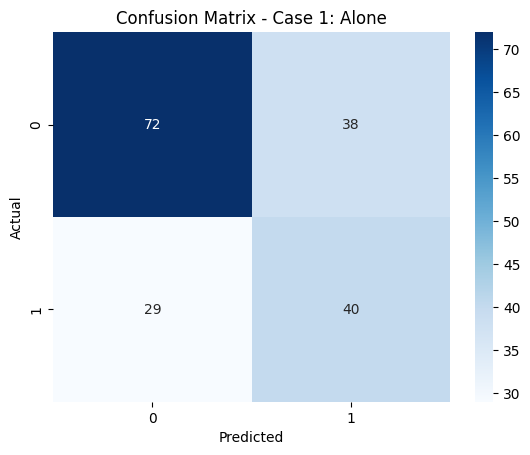

In [19]:
# Create confusion matrix for test predictions (Case 1)
cm1 = confusion_matrix(y1_test, y1_test_pred)

# Plot heatmap
sns.heatmap(cm1, annot=True, cmap='Blues')
plt.title('Confusion Matrix - Case 1: Alone')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

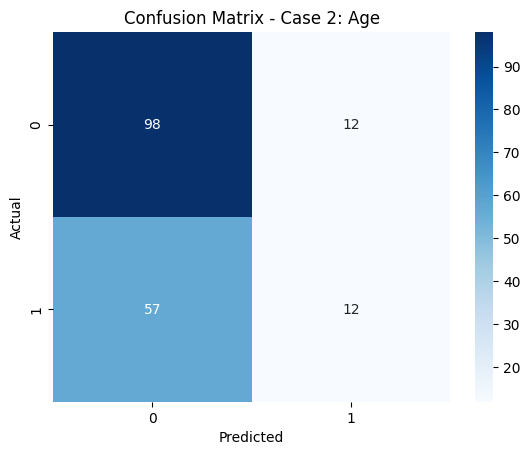

In [20]:
# Create confusion matrix for test predictions (Case 2)
cm2 = confusion_matrix(y2_test, y2_test_pred)

# Plot heatmap
sns.heatmap(cm2, annot=True, cmap='Blues')
plt.title('Confusion Matrix - Case 2: Age')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

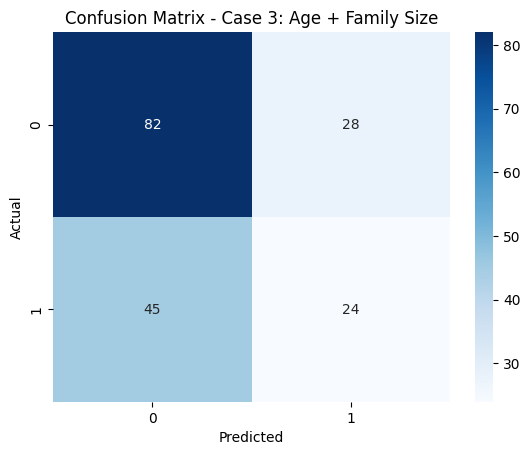

In [21]:
# Create confusion matrix for test predictions (Case 3)
cm3 = confusion_matrix(y3_test, y3_test_pred)

# Plot heatmap
sns.heatmap(cm3, annot=True, cmap='Blues')
plt.title('Confusion Matrix - Case 3: Age + Family Size')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 4.5 Report Decision Tree Plot

Plot the decision tree model for each case. We give the plotter the names of the features and the names of the categories for the target.

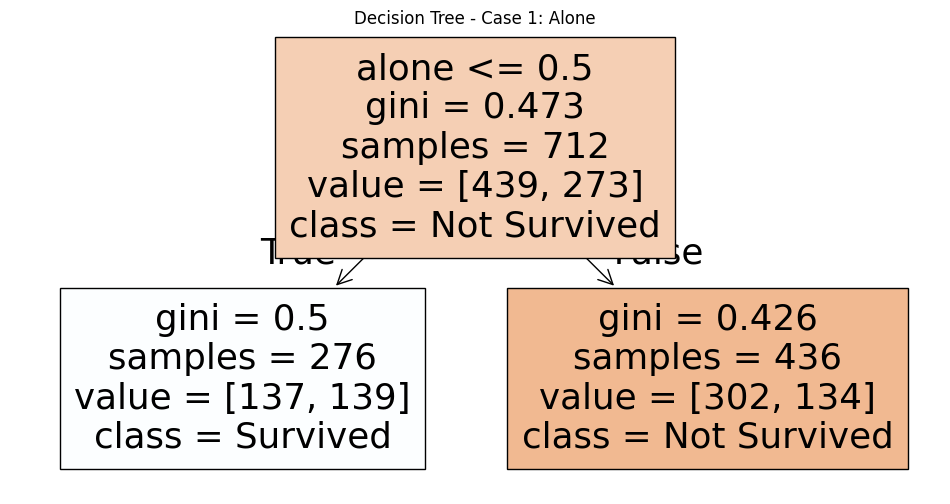

In [22]:
# Plot Decision Tree for Case 1
fig = plt.figure(figsize=(12, 6))
plot_tree(tree_model1,
          feature_names=X1.columns,
          class_names=['Not Survived', 'Survived'],
          filled=True)
plt.title("Decision Tree - Case 1: Alone")
plt.show()

# Save image
fig.savefig("tree_case1_alone.png")

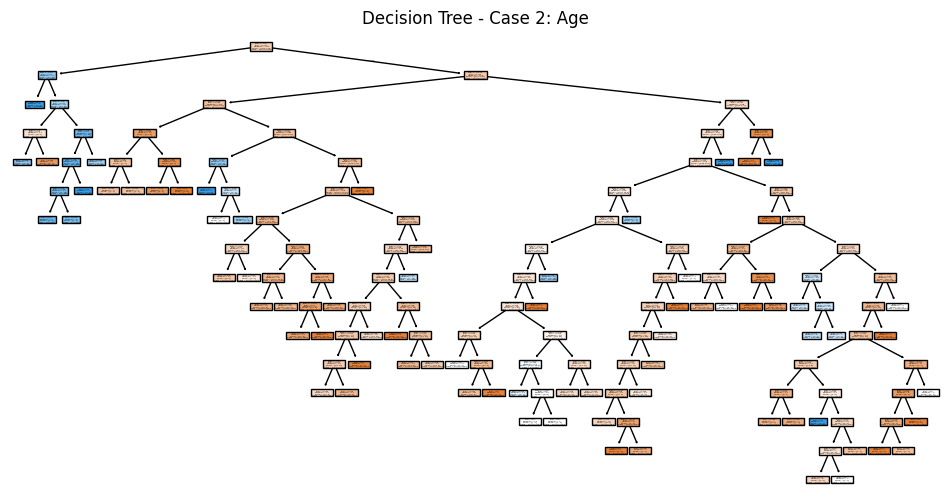

In [24]:
# Plot Decision Tree for Case 2
fig = plt.figure(figsize=(12, 6))
plot_tree(tree_model2,
          feature_names=X2.columns,
          class_names=['Not Survived', 'Survived'],
          filled=True)
plt.title("Decision Tree - Case 2: Age")
plt.show()

# Save image
fig.savefig("tree_case2_age.png")

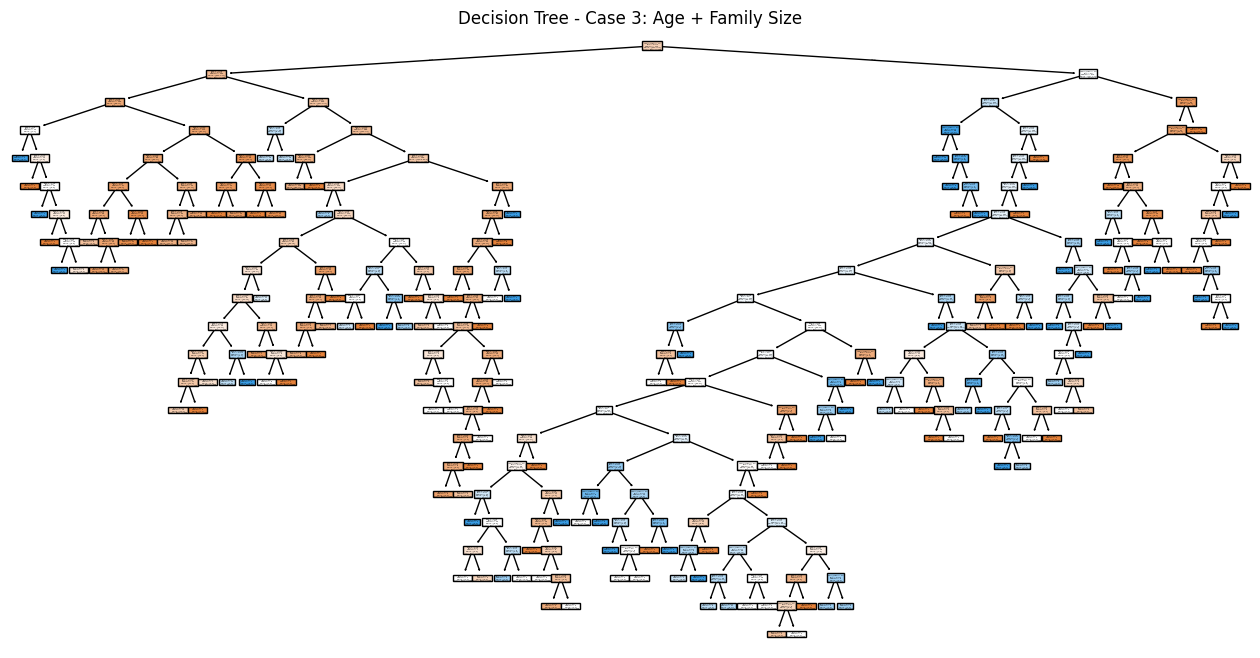

In [25]:
# Plot Decision Tree for Case 3
fig = plt.figure(figsize=(16, 8))
plot_tree(tree_model3,
          feature_names=X3.columns,
          class_names=['Not Survived', 'Survived'],
          filled=True)
plt.title("Decision Tree - Case 3: Age + Family Size")
plt.show()

# Save image
fig.savefig("tree_case3_age_family.png")

## Reflection 4:
<b>How well did the different cases perform?  </b>

Here is a table that summarizes test f1-scores and accuracy.
| Metric | Case 1 | Case 2 | Case 3 |
| :--- | :--- | :--- | :--- |
| **F1-Score (Class 0)** | 0.68 | 0.74 | 0.69 |
| **F1-Score (Class 1)** | 0.54 | 0.26 | 0.40 |
| **Accuracy** | 0.63 | 0.61 | 0.59 |
 

<b>The usefulness of f1-scores:  </b>
The f1-score is a harmonic average of precision and recall. It can be a more balanced metric for data with different class sizes.  

<b>Are there any surprising results?  </b>
In general, the cases did reasonably well at correctly predicting 0 (did not survive), but less well at correctly predicting 1 (survived). Looking at the confusion matrices, models that predicted 1 were only correct about half the time.  

Perhaps not all surprising in that case 3 did better at differentiating between 0 and 1 than case 2, aided by the additional information of family size.

Case 1 has the best f1-core for 1, and also boasts a score not far behind the other cases for 0. Correctly differentiating 0 and 1 is important; we could predict 0 for all instances and still have a reasonably high accuracy because of the class sizes, but only maximizing accuracy is not the goal.

<b>Which inputs worked better?  </b>
I prefer case1 with the "alone" feature. It has both the highest f1-score for 1 and the highest accuracy of all cases.


## Section 5. Compare Alternative Models (SVC, NN)

In a Support Vector Machine, the kernel function defines how the algorithm transforms data to find a hyperplane that separates the classes. If the data is not linearly separable, changing the kernel can help the model find a better decision boundary.

SVC Kernel: Common Types

RBF (Radial Basis Function) – Most commonly used; handles non-linear data well (default)
Linear – Best for linearly separable data (straight line separation)
Polynomial – Useful when the data follows a curved pattern
Sigmoid – Similar to a neural network activation function; less common
Commenting the options in and out in the code can be helpful. The analyst decides which to use based on their understanding of the results. 

In [26]:
# # RBF Kernel (default) - same as calling SVC()
# svc_model = SVC(kernel='rbf')
# svc_model.fit(X_train, y_train)

# # Linear Kernel
# svc_model = SVC(kernel='linear')
# svc_model.fit(X_train, y_train)

# # Polynomial Kernel (e.g., with degree=3)
# svc_model = SVC(kernel='poly', degree=3)
# svc_model.fit(X_train, y_train)

# # Sigmoid Kernel
# svc_model = SVC(kernel='sigmoid')
# svc_model.fit(X_train, y_train)

SVC Kernel: How to Choose

Start with linear if you suspect the data is linearly separable.
Use RBF if the data is complex or you aren’t sure.
Try polynomial if the data seems to follow a curved boundary.
Use sigmoid for experiments (rarely the best choice).
SVC Kernel: Common Issues and Techniques

If the model takes too long to train, reduce the degree for polynomial kernels.
If support_vectors_ gives an error, the data may not be separable with the current kernel. Try switching to RBF or adjusting the C (regularization) value.
If the model misclassifies many points, then increase/decrease gamma or C.
Your process is valuable - record the work you do and the temporary results in your reflections and insights. To show your skills, show and tell us about your analysis process. Professional communication is key.

## 5.1 Train and Evaluate Model (SVC)